In [32]:
import os
import tqdm as tqdm
import numpy as np
import copy

# 处理服务器中evo的可视化问题
import evo
# from evo.tools.settings import SETTINGS
# SETTINGS['plot_backend'] = 'Agg'

# from evo.tools import file_interface, plot
from evo.core.geometry import GeometryException
import evo.main_ape as main_ape
from evo.core import sync, metrics
from evo.core.trajectory import PoseTrajectory3D, PosePath3D

import matplotlib.pyplot as plt #绘图

print("Successfully import ultils")

Successfully import ultils


In [33]:
def make_evo_traj_gt(poses_N_x_7, tss_us):
    assert poses_N_x_7.shape[1] == 7
    assert poses_N_x_7.shape[0] > 10
    assert tss_us.shape[0] == poses_N_x_7.shape[0]

    traj_evo = PoseTrajectory3D(
        positions_xyz=poses_N_x_7[:,:3],
        # orientations_quat_wxyz=poses_N_x_7[:,3:],
        orientations_quat_wxyz = poses_N_x_7[:, [6,3,4,5]],#gt存储的是xyzw
        timestamps=tss_us/1e6)#转换为秒
    return traj_evo

def make_evo_traj_deio(poses_N_x_7, tss_us):
    assert poses_N_x_7.shape[1] == 7
    assert poses_N_x_7.shape[0] > 10
    assert tss_us.shape[0] == poses_N_x_7.shape[0]

    traj_evo = PoseTrajectory3D(
        positions_xyz=poses_N_x_7[:,:3],
        # orientations_quat_wxyz=poses_N_x_7[:,3:],
        orientations_quat_wxyz = poses_N_x_7[:, [5,6,3,4]],#存储的是yzwx(由于原代码的bug导致的,注意统一代码输出为xyzw而evo中需要用的是wxyz即可)
        timestamps=tss_us/1e6)#转换为秒
    return traj_evo

def load_gt_us(path, skiprows=0):
    traj_ref = np.loadtxt(path, delimiter=" ", skiprows=skiprows)
    tss_gt_us = traj_ref[:, 0].copy() 
    assert np.all(tss_gt_us == sorted(tss_gt_us))
    assert traj_ref.shape[0] > 0
    assert traj_ref.shape[1] == 8

    return tss_gt_us, traj_ref[:, 1:]

from scipy.spatial.transform import Rotation
def get_euler_from_quat(quat):
    rpy = Rotation.from_quat(quat).as_euler('zyx', degrees=True)
    return rpy

def get_euler_evo(traj: PosePath3D):
    rpy = traj.get_orientations_euler(axes='sxyz')
    rpy = np.rad2deg(rpy)
    return rpy


def get_euler_from_rot(rot):
    rpy = Rotation.from_matrix(rot).as_euler('zyx', degrees=True)
    return rpy

import matplotlib.ticker as ticker
def plot_data(ax, t, data, x_label, y_label, legend_handles):
    # if tuple/list and len > 1
    line = []
    for i in range(len(data)):
        _line, = ax.plot(t, data[i], linestyle=styles[i], color=colors[i], linewidth=linewidth)
        line.append(_line)
    
    if not legend_handles:
        legend_handles.extend([(l, legend_names[i]) for i, l in enumerate(line)])
    
    # other settings
    if x_label is not None:
        ax.set_xlabel(x_label, fontsize=figfontsize, labelpad=5)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbin_xmajor))
    ax.tick_params(axis='x', direction='in', labelsize=figfontsize)
    
    if y_label is not None:
        ax.set_ylabel(y_label, fontsize=figfontsize)
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbin_ymajor))
    ax.tick_params(axis='y', direction='in', labelsize=figfontsize)
    
    ax.grid(True)

print("Successfully define several functions")

Successfully define several functions


Evaluation for DAVIS240c dataset in DEIO


/tmp/ipykernel_2937245/490281274.py:208: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


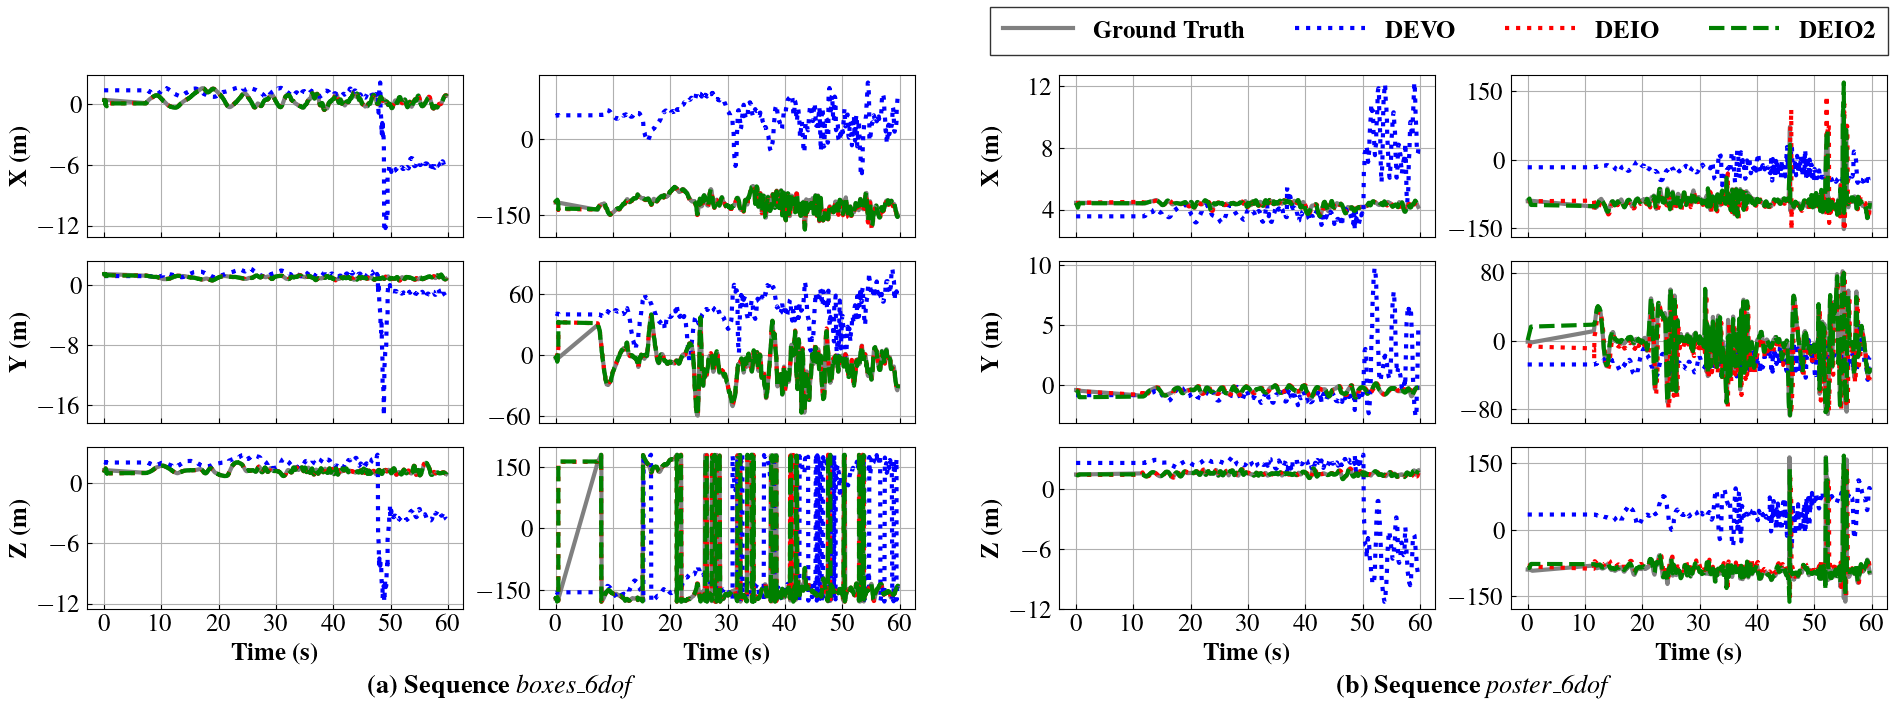

In [59]:
print("Evaluation for DAVIS240c dataset in DEIO")
indir="/media/lfl-data2/davis240c/"

target_dirs = [
                "boxes_6dof",
                # "hdr_poster",
                "poster_6dof",
]

# settings
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times"
})

from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(18, 6))
gs = []
gs_space = [[0, 0.46], [0.54, 1]]
for i in range(len(target_dirs)):
    _gs = GridSpec(3, 2, 
                  width_ratios=[1, 1], 
                  left=gs_space[i][0], right=gs_space[i][1],
                  bottom=0.06, top=0.95,
                  wspace=None, hspace=0.15)   

    gs.append(_gs)

subfig_order_each_seq = ['x', 'roll', 'y', 'pitch', 'z', 'yaw']

legend_names = [r'\textbf{Ground Truth}', r'\textbf{DEVO}', r'\textbf{DEIO}', r'\textbf{DEIO2}']
styles = ['-', ':', ':', '--']
colors = ['grey', 'blue', 'red', 'green']

data_type_settings = {
    'x'    : {'ylabel': r'\textbf{X (m)}'      , 'xlabel': r'\textbf{Time (s)}'},
    'y'    : {'ylabel': r'\textbf{Y (m)}'      , 'xlabel': r'\textbf{Time (s)}'},
    'z'    : {'ylabel': r'\textbf{Z (m)}'      , 'xlabel': r'\textbf{Time (s)}'},
    'roll' : {'ylabel': r'\textbf{Roll (deg)}' , 'xlabel': r'\textbf{Time (s)}'},
    'pitch': {'ylabel': r'\textbf{Pitch (deg)}', 'xlabel': r'\textbf{Time (s)}'},
    'yaw'  : {'ylabel': r'\textbf{Yaw (deg)}'  , 'xlabel': r'\textbf{Time (s)}'},
}

linewidth = 3
figfontsize = 18
nbin_ymajor = 3
nbin_xmajor = 8

legend_handles = []
exp_data = {}
i=-1
for root, dirs, files in os.walk(indir):
    for d in dirs:
        # 构建完整路径 data_path
        datapath_val = os.path.join(root, d)

        # 检查是否为目标文件夹之一
        if os.path.basename(datapath_val) in target_dirs:
            sequence_name = os.path.basename(datapath_val)

            # 获取轨迹
            _tss_gt_us, _traj_gt = load_gt_us(os.path.join(datapath_val, f"gt_stamped_left.txt"))#获取真实轨迹(相对时间)
            tss_gt_us, traj_gt = load_gt_us(os.path.join(datapath_val, f"raw_gt_stamped_ns_left.txt"))#获取真实轨迹(绝对时间)
            t0 = tss_gt_us[0]-_tss_gt_us[0]#获取初始化时间

            i=i+1

            # 获取deio估算的轨迹
            if sequence_name == "boxes_6dof":
                tss_devo_us, traj_devo = load_gt_us("/home/gwp/raw_DEVO/results/davis240c_evs/2024-09-06_boxes_6dof/Boxes_6Dof_trial_0_step_DEVO/Boxes_6Dof_Trial01.txt")
                tss_devo_us=tss_devo_us + t0

                tss_deio2_us, traj_deio2 = load_gt_us("/home/gwp/DEIO2/results/davis240c/EVO_GBA_IMU/2025-04-05/boxes_6dof/Boxes_6Dof_trial_4_step_DEVO/Boxes_6Dof_Trial04.txt")
                tss_deio2_us=tss_deio2_us + t0

                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/DAVIS240C/2024-10-06_boxes_6dof/Boxes_6Dof_trial_1_step_DEVOimu/Boxes_6Dof_Trial01.txt")
            elif sequence_name == "hdr_poster":
                tss_devo_us, traj_devo = load_gt_us("/home/gwp/raw_DEVO/results/davis240c_evs/2024-09-06_hdr_poster/Hdr_Poster_trial_0_step_DEVO/Hdr_Poster_Trial01.txt") 
                tss_devo_us=tss_devo_us + t0  

                tss_deio2_us, traj_deio2 = load_gt_us("/home/gwp/DEIO2/results/davis240c/EVO_GBA_IMU/2025-04-05/hdr_poster/Hdr_Poster_trial_3_step_DEVO/Hdr_Poster_Trial03.txt")
                tss_deio2_us=tss_deio2_us + t0

                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/DAVIS240C/2024-10-06_hdr_poster/Hdr_Poster_trial_1_step_DEVOimu/Hdr_Poster_Trial01.txt")   
            elif sequence_name == "poster_6dof":
                tss_devo_us, traj_devo = load_gt_us("/home/gwp/raw_DEVO/results/davis240c_evs/2024-09-06_poster_6dof/Poster_6Dof_trial_0_step_DEVO/Poster_6Dof_Trial01.txt")
                tss_devo_us=tss_devo_us + t0

                tss_deio2_us, traj_deio2 = load_gt_us("/home/gwp/DEIO2/results/davis240c/EVO_GBA_IMU/2025-04-05/poster_6dof/Poster_6Dof_trial_3_step_DEVO/Poster_6Dof_Trial03.txt")
                tss_deio2_us=tss_deio2_us + t0

                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/DAVIS240C/2024-10-06_poster_6dof/Poster_6Dof_trial_1_step_DEVOimu/Poster_6Dof_Trial01.txt")     

            gt_traj = make_evo_traj_gt(traj_gt, tss_gt_us)
            deio2_traj = make_evo_traj_gt(traj_deio2, tss_deio2_us)

            deio_traj = make_evo_traj_deio(traj_deio, tss_deio_us)
            devo_traj = make_evo_traj_deio(traj_devo, tss_devo_us)

            _n_to_align=1000;

            gt_traj, devo_traj = sync.associate_trajectories(gt_traj, devo_traj, max_diff=1)
            gt_traj, deio_traj = sync.associate_trajectories(gt_traj, deio_traj, max_diff=1)
            gt_traj, deio2_traj = sync.associate_trajectories(gt_traj, deio2_traj, max_diff=1)
            # 对齐轨迹(空间维度上的)
            if 1:
                try:
                    devo_traj.align(gt_traj, correct_scale=False,n=_n_to_align)
                    deio_traj.align(gt_traj, correct_scale=False,n=_n_to_align)
                    deio2_traj.align(gt_traj, correct_scale=False,n=_n_to_align)                                    
                except GeometryException as e:
                    print("Plotting error:", e)

            exp_data[sequence_name] = {}

            #获取下面最短的长度
            min_len = min(gt_traj.num_poses, devo_traj.num_poses, deio_traj.num_poses, deio2_traj.num_poses)

            # use the timestamps from predicted data
            exp_data[sequence_name]['t'] = (gt_traj.timestamps - gt_traj.timestamps[0])[:min_len]

            exp_data[sequence_name]['deio2_xyz'] = deio2_traj.positions_xyz[:min_len]
            exp_data[sequence_name]['deio_xyz'] = deio_traj.positions_xyz[:min_len]
            exp_data[sequence_name]['devo_xyz'] = devo_traj.positions_xyz[:min_len]
            exp_data[sequence_name]['gt_xyz']   = gt_traj.positions_xyz[:min_len]

            # calculate rpy
            # exp_data[sequence_name]['deio_rpy'] = get_euler_from_quat(deio_traj._orientations_quat_wxyz)
            # exp_data[sequence_name]['devo_rpy'] = get_euler_from_quat(devo_traj._orientations_quat_wxyz)
            # exp_data[sequence_name][f'gt_rpy'] = get_euler_from_quat(gt_traj._orientations_quat_wxyz)

            exp_data[sequence_name]['deio2_rpy'] = get_euler_evo(deio2_traj)[:min_len]
            exp_data[sequence_name]['deio_rpy'] = get_euler_evo(deio_traj)[:min_len]
            exp_data[sequence_name]['devo_rpy'] = get_euler_evo(devo_traj)[:min_len]
            exp_data[sequence_name][f'gt_rpy'] = get_euler_evo(gt_traj)[:min_len]
            
        
            
            # %matplotlib inline
            # plot_trajectory_xyz(deio_traj=copy.deepcopy(deioEst),devo_traj=copy.deepcopy(devoEst),gt_traj=copy.deepcopy(evoGT), _n_to_align=_n_to_align);
            # plot_trajectory_rpy(deio_traj=copy.deepcopy(deioEst),devo_traj=copy.deepcopy(devoEst),gt_traj=copy.deepcopy(evoGT), _n_to_align=_n_to_align);

            for j, data_type in enumerate(subfig_order_each_seq):#遍历画xyz和rpy
                if data_type in ['x', 'y', 'z']:
                    idx = ['x', 'y', 'z'].index(data_type)
                    data = (exp_data[sequence_name]['gt_xyz'][:, idx], exp_data[sequence_name]['devo_xyz'][:, idx], exp_data[sequence_name]['deio_xyz'][:, idx], exp_data[sequence_name]['deio2_xyz'][:, idx])
                elif data_type in ['roll', 'pitch', 'yaw']:
                    idx = ['r', 'p', 'y'].index(data_type[0])
                    data = (exp_data[sequence_name][f'gt_rpy'][:, idx], exp_data[sequence_name][f'devo_rpy'][:, idx], exp_data[sequence_name][f'deio_rpy'][:, idx], exp_data[sequence_name][f'deio2_rpy'][:, idx])
                
                row_id = j // 2
                col_id = j % 2
                ax = fig.add_subplot(gs[i][row_id, col_id])
                if row_id == 2:
                    x_label = data_type_settings[data_type]['xlabel']
                else:
                    x_label = None
                if col_id == 0:
                    y_label = data_type_settings[data_type]['ylabel']
                else:
                    y_label = None

                plot_data(ax, t=exp_data[sequence_name]['t'], data=data, x_label=x_label, y_label=y_label, legend_handles=legend_handles)
     
    # 使用break限制os.walk只遍历indir的第一层
    break

# modify the figure layout
axes = fig.get_axes()
axes = np.array(axes).reshape(len(target_dirs), 3, 2).transpose(1, 0, 2).reshape(3, 2*len(target_dirs))

# each column share x axis
for j in range(2*len(target_dirs)):
    ax_shared = axes[-1, j]
    for i in range(2):
        ax = axes[i, j]
        ax.sharex(ax_shared)
        # ax_shared.get_shared_x_axes().join(ax_shared, ax)
        # only the last row has x ticks
        ax.tick_params(axis='x', direction='in', labelbottom=False)

# align y labels
for i in range(len(target_dirs)):
    fig.align_ylabels(axes[:, i*2:(i+1)*2])

# add a single legend for all plots
legend = fig.legend(*zip(*legend_handles), 
                    loc='upper right', 
                    ncol=4, 
                    fontsize=figfontsize,
                    frameon=True, 
                    bbox_to_anchor=(1.006, 1.08),
                    handlelength=2.8,
                    columnspacing=2)
legend.get_frame().set_edgecolor("black")
legend.get_frame().set_boxstyle('Square', pad=0.1)

# set x title for each sequence
# Add ghost axes and titles
title_each_gs = [
    rf'\textbf{{(a) Sequence}} \textit{{{target_dirs[0]}}}', 
    rf'\textbf{{(b) Sequence}} \textit{{{target_dirs[1]}}}'
]

fig.text(0.23, -0.07, title_each_gs[0], ha='center', va='center', fontsize=figfontsize+1)
fig.text(0.77, -0.07, title_each_gs[1], ha='center', va='center', fontsize=figfontsize+1)

plt.tight_layout()
plt.show()


